## Week4 Evaluation Homework

In [2]:
import pandas as pd
df=pd.read_csv('data.csv')

In [5]:
df[::10]

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
10,paid_ads,retail,2,79276.0,employed,middle_east,2,0.92,1
20,social_media,technology,4,62067.0,student,north_america,4,0.43,1
30,paid_ads,finance,4,60617.0,self_employed,north_america,0,0.54,1
40,social_media,healthcare,1,78509.0,student,north_america,5,0.75,1
...,...,...,...,...,...,...,...,...,...
1420,paid_ads,technology,5,31551.0,unemployed,australia,0,0.72,1
1430,social_media,NaN,4,40938.0,self_employed,australia,3,0.14,1
1440,referral,retail,2,67832.0,employed,australia,2,0.26,1
1450,referral,other,2,68034.0,unemployed,africa,4,0.79,0


In [6]:
df.dtypes 

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [17]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical =['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [ ]:
df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna('NA')

In [13]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

In [14]:
from sklearn.metrics import roc_auc_score

for feature in numerical:
    auc = roc_auc_score(y_train, df_train[feature])
    
    # If AUC < 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
        print(f'{feature}: {auc:.4f} (inverted)')
    else:
        print(f'{feature}: {auc:.4f}')

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145


Answer: number_of_courses_viewed - highest AUC

## Question 2: Training the model

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [27]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [28]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred).round(3)

np.float64(0.817)

Answer: not exactly matched, but closer to either 0.72 or 0.92

## Question 3: Precision and Recall

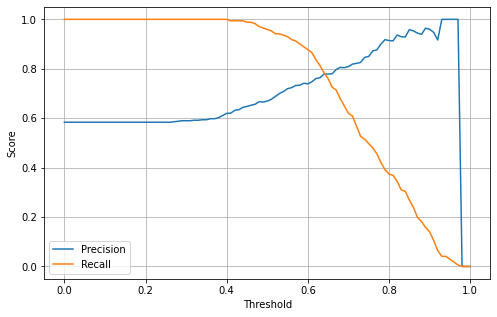

In [ ]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate at different thresholds
thresholds = np.linspace(0, 1, 101) 
precisions = []
recalls = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

Answer: around 0.65, so closer to 0.545 or 0.745

## Question 4: F1 score

In [34]:
from sklearn.metrics import f1_score

# Calculate F1 score at different thresholds
thresholds = np.linspace(0, 1, 101)
f1_scores = []

for t in thresholds:
    y_pred_binary = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, y_pred_binary, zero_division=0)
    f1_scores.append(f1)

In [35]:
# Find maximum F1 score
max_f1_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[max_f1_idx]
max_f1 = f1_scores[max_f1_idx]

print(f'Optimal threshold: {optimal_threshold:.3f}')
print(f'Maximum F1 score: {max_f1:.3f}')

Optimal threshold: 0.570
Maximum F1 score: 0.812


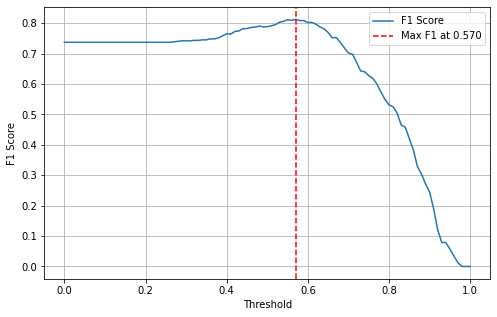

In [36]:
# Plot F1 score
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Max F1 at {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

Answer: 0.54

## Question 5: 5-Fold CV

In [38]:
from sklearn.model_selection import KFold

# Prepare full training data
dicts_full_train = df_full_train[df_full_train.columns.drop('converted')].to_dict(orient='records')
y_full_train = df_full_train.converted.values

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(dicts_full_train):
    # Split data for this fold
    train_dicts = [dicts_full_train[i] for i in train_idx]
    val_dicts = [dicts_full_train[i] for i in val_idx]
    
    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]
    
    # One-hot encoding
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dicts)
    X_val_fold = dv.transform(val_dicts)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict and calculate AUC
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)
    
    print(f'Fold AUC: {auc:.4f}')

# Calculate statistics
print(f'\nMean AUC: {np.mean(scores):.3f}')
print(f'Std AUC: {np.std(scores):.3f}')

Fold AUC: 0.8061
Fold AUC: 0.8714
Fold AUC: 0.7754
Fold AUC: 0.8018
Fold AUC: 0.8558

Mean AUC: 0.822
Std AUC: 0.036


Answer: closer to 0.06

In [41]:
from sklearn.model_selection import KFold

# Prepare full training data
dicts_full_train = df_full_train[df_full_train.columns.drop('converted')].to_dict(orient='records')
y_full_train = df_full_train.converted.values

# Hyperparameter values to test
C_values = [0.000001, 0.001, 1]

# Store results
results = []

for C in C_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(dicts_full_train):
        # Split data
        train_dicts = [dicts_full_train[i] for i in train_idx]
        val_dicts = [dicts_full_train[i] for i in val_idx]
        
        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]
        
        # One-hot encoding
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dicts)
        X_val_fold = dv.transform(val_dicts)
        
        # Train model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Evaluate
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)
    
    mean_score = np.round(np.mean(scores), 3)
    std_score = np.round(np.std(scores), 3)
    
    results.append({
        'C': C,
        'mean': mean_score,
        'std': std_score
    })
    
    print(f'C={C}: mean={mean_score:.3f}, std={std_score:.3f}')

# Find best C
results_df = pd.DataFrame(results)
print('\nResults:')
print(results_df)


C=1e-06: mean=0.560, std=0.024
C=0.001: mean=0.867, std=0.029
C=1: mean=0.822, std=0.036

Results:
          C   mean    std
0  0.000001  0.560  0.024
1  0.001000  0.867  0.029
2  1.000000  0.822  0.036


Answer: 0.001